In [1]:
%pip install numpy==1.26.4
%pip install pandas==2.2.3
%pip install tensorflow==2.17.0
%pip install keras==3.5.0
%pip install matplotlib==3.9.2
%pip install scikit-learn==1.5.2
%pip install scikit-image==0.24.0

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, Dropout
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 82.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.6.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 56.7 MB/s eta 0:00:00
  Attempting uninstal

In [2]:
# Load the CSV files as pandas dataframes
degraded_images = pd.read_csv('/content/drive/MyDrive/training_set.csv')
target_images = pd.read_csv('/content/drive/MyDrive/target.csv')

# Convert the dataframes into numpy arrays for faster computing
training_data = degraded_images.to_numpy()
target_data = target_images.to_numpy()

# Initializing the number of examples, size, and channel of the images
IMAGE_SIZE = 48
CHANNEL = 1
NUMBER_OF_EXAMPLES = 30000 # There are 30,000 images in the csv

# Reshaping our data into a 2D shape for training
training_data = training_data.reshape((NUMBER_OF_EXAMPLES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))
target_data = target_data.reshape((NUMBER_OF_EXAMPLES, IMAGE_SIZE, IMAGE_SIZE, CHANNEL))

# Split the data into training and validation sets
degrade_train, degrade_val, target_train, target_val = train_test_split(training_data, target_data, test_size=0.2, random_state=42)

# Print the shapes of the arrays to confirm
print(f"Training degraded data shape: {degrade_train.shape}, Training target data shape: {target_train.shape}")
print(f"Validation degraded data shape: {degrade_val.shape}, Validation target data shape: {target_val.shape}")


Training degraded data shape: (24000, 48, 48, 1), Training target data shape: (24000, 48, 48, 1)
Validation degraded data shape: (6000, 48, 48, 1), Validation target data shape: (6000, 48, 48, 1)


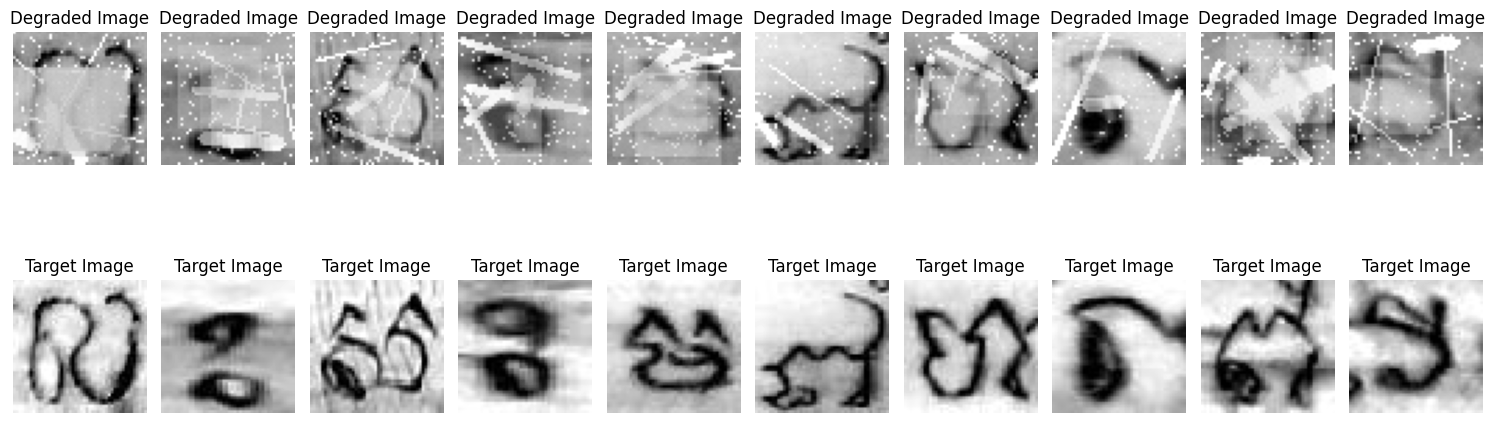

In [3]:
# Number of images to display
number_of_images_to_display = 10

# Set up the figure
plt.figure(figsize=(15, 6))

# Loop through both the degrade set and target set, and plot 10 corresponding images
for i in range(number_of_images_to_display):
    # Plot degraded images (X_train)
    plt.subplot(2, number_of_images_to_display, i + 1)
    plt.imshow(degrade_train[i].reshape(48, 48), cmap='gray')  # Reshape if necessary
    plt.title('Degraded Image')
    plt.axis('off')  # Hide axes

    # Plot target images (y_train)
    plt.subplot(2, number_of_images_to_display, i + 1 + number_of_images_to_display)
    plt.imshow(target_train[i].reshape(48, 48), cmap='gray')  # Reshape if necessary
    plt.title('Target Image')
    plt.axis('off')  # Hide axes

# Show the plot
plt.tight_layout()
plt.show()

# The U-Net architecture  
## About U-Net architecture  
The U-Net architecture is unique because it consists of a contracting path (encoder) and a expansive path (decoder). The contracting path capture information and reduce the spatial dimension of the input, whereas the expansive path upsample the reduced spatial dimension with the help of the skip-connection (copy and crop), while retaining all the essential information.    

The contracting path in U-Net is responsible for identifying the relevant features in the input image. The encoder layers perform convolutional operations that reduce the spatial resolution of the feature maps while increasing their depth, thereby capturing increasingly abstract representations of the input. This contracting path is similar to the feedforward layers in other convolutional neural networks. On the other hand, the expansive path works on decoding the encoded data and locating the features while maintaining the spatial resolution of the input. The decoder layers in the expansive path upsample the feature maps, while also performing convolutional operations. The skip connections from the contracting path help to preserve the spatial information lost in the contracting path, which helps the decoder layers to locate the features more accurately (GeeksForGeeks).    
## Modified U-Net
However, for our image restoration problem, we want to utilize the efficiency and robustness of the U-net architecture to encode the damaged text, and decode it into a clean text. To do this, we would have to build the model itself. The model is sperated into 3 component; the encoder block, the decoder block, and the bottle neck. For the model to output a clean image, we will use Mean-Squared-Error as the loss function, and the original image (non-damaged text) as the label. The model will compare its output to the original image and calculate its loss based on pixel-to-pixel comparison. Furthermore, we will also be utilizing Batch Normalization, and Dropout to reduce overfitting. ReLu activation will be use after the Batch Normalization. Dropout will be use after the Convolutional operations. We will also be using He Normal as our weights initializer.

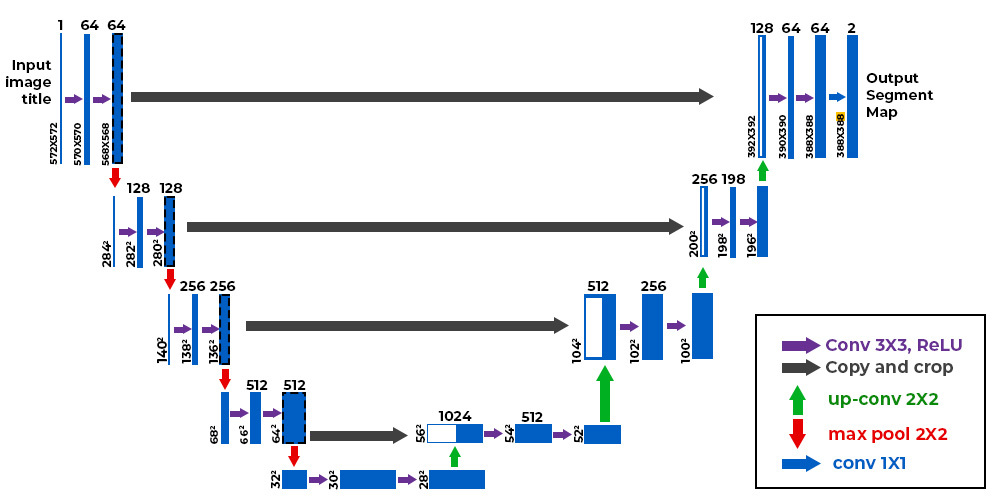

In [4]:
def encoder_block(inputs, filters, drop_out=0.1):
    """
    The encoder block consists of convolutional layers, and max pooling layers.
    Dropout is use after the first convolutional layer to ensure generalization.
    Batch normalization is used after the second convolutional layer to ensure all batches are normalized before activation.

    Parameters:
        -inputs: Input features of previous block or starting input
        -filters: Number of feature map per layer
        -drop_out: Rate of neuron randomly dropped

    Returns:
        -activation: Return the activated value of the normalized convolutional output
        -pool_block: Return the down-sized feature mapped of the convolutional output
    """

    convolution_block = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(inputs)
    convolution_block = Dropout(drop_out)(convolution_block)
    convolution_block = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(convolution_block)
    batch_normalization = BatchNormalization()(convolution_block)
    activation = Activation('relu')(batch_normalization)
    pool_block = MaxPooling2D((2, 2))(activation)

    return activation, pool_block

In [5]:
def decoder_block(inputs, skip_features, filters):
    """
    The decoder block consists of transposed layers, convolutional layers, and concatination (which is the skip connection)
    Batch Normalization is used to normalized the batches after each convolutional operation

    Parameters:
        -inputs: Input features of the previous block
        -skip_features: Activated features from the encoder
        -filters: Number of feature map per layer

    Returns:
        -activation: Return the activated output of the convolutional layer output
    """

    upsample_block = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    upsample_block = concatenate([upsample_block, skip_features])

    convolution_block = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(upsample_block)
    batch_normalization = BatchNormalization()(convolution_block)
    activation = Activation('relu')(batch_normalization)

    convolution_block = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(activation)
    batch_normalization = BatchNormalization()(convolution_block)
    activation = Activation('relu')(batch_normalization)

    return activation


In [6]:
def bottleneck(inputs, filters, drop_out):
    """
    The bottle neck consists ofconvolutional layers, and max pooling layers.
    Dropout is use after the first convolutional layer to ensure generalization.
    Batch normalization is used after the second convolutional layer to ensure all batches are normalized before activation.

    Parameters:
        -inputs: Input features of previous block
        -filters: Number of feature map per layer
        -drop_out: Rate of neuron randomly dropped

    Returns:
        -bottle_neck: Return the output of the bottle_neck layer
    """

    bottle_neck = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(inputs)
    bottle_neck = BatchNormalization()(bottle_neck)
    bottle_neck = Activation('relu')(bottle_neck)
    bottle_neck = Dropout(drop_out)(bottle_neck)
    bottle_neck = Conv2D(filters, (3, 3), padding='same', kernel_initializer=he_normal())(bottle_neck)

    return bottle_neck

In [7]:
def u_net_model(input_shape):
    inputs = tf.keras.Input(input_shape)

    # Contracting path
    encoder1, pool1 = encoder_block(inputs, filters=64, drop_out=0.1)
    encoder2, pool2 = encoder_block(pool1, filters=128, drop_out=0.1)
    encoder3, pool3 = encoder_block(pool2, filters=256, drop_out=0.2)
    encoder4, pool4 = encoder_block(pool3, filters=512, drop_out=0.2)

    # Bottle neck
    bottle_neck = bottleneck(pool4, filters=1024, drop_out=0.3)

    # Expansive path
    decoder1 = decoder_block(bottle_neck, encoder4, filters=512)
    decoder2 = decoder_block(decoder1, encoder3, filters=256)
    decoder3 = decoder_block(decoder2, encoder2, filters=128)
    decoder4 = decoder_block(decoder3, encoder1, filters=64)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(decoder4)  # Single-channel for grayscale restoration

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [8]:
# Build the U-Net model
input_shape = (48, 48, 1)  # Grayscale images
model = u_net_model(input_shape)

learning_rate = 0.0003
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 48, 48, 1)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 48, 48, 64)     │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 48, 48, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 48, 48, 64)     │         36,928 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 48, 48, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 48, 48, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 24, 24, 64)     │              0 │ activation[0][0]       │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 24, 24, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 24, 24, 128)    │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 24, 24, 128)    │        147,584 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 24, 24, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 24, 24, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 12, 12, 128)    │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 12, 12, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 12, 12, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 12, 12, 256)    │        590,080 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 12, 12, 256)    │          1,024 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 31,046,209 (118.43 MB)

 Trainable params: 31,038,401 (118.40 MB)

 Non-trainable params: 7,808 (30.50 KB)

In [9]:
# Train the model
BATCH_SIZE = 64
EPOCHS = 30
history = model.fit(degrade_train,
                    target_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(degrade_val, target_val),
                    shuffle=True)

Epoch 1/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 114s 194ms/step - loss: 0.0291 - mean_absolute_error: 0.1216 - val_loss: 0.0245 - val_mean_absolute_error: 0.1111
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 114s 198ms/step - loss: 0.0114 - mean_absolute_error: 0.0741 - val_loss: 0.0110 - val_mean_absolute_error: 0.0762
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 199ms/step - loss: 0.0080 - mean_absolute_error: 0.0618 - val_loss: 0.0103 - val_mean_absolute_error: 0.0797
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - loss: 0.0063 - mean_absolute_error: 0.0547 - val_loss: 0.0080 - val_mean_absolute_error: 0.0645
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 186ms/step - loss: 0.0053 - mean_absolute_error: 0.0498 - val_loss: 0.0059 - val_mean_absolute_error: 0.0553
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 86s 198ms/step - loss: 0.0047 - mean_absolute_error: 0.0467 - val_loss: 0.0049 - val_mean_absolute_error: 0.0494
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 198ms/step - loss: 0.0042 - mean_abs

## Plotting the loss curves of training and validation set

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


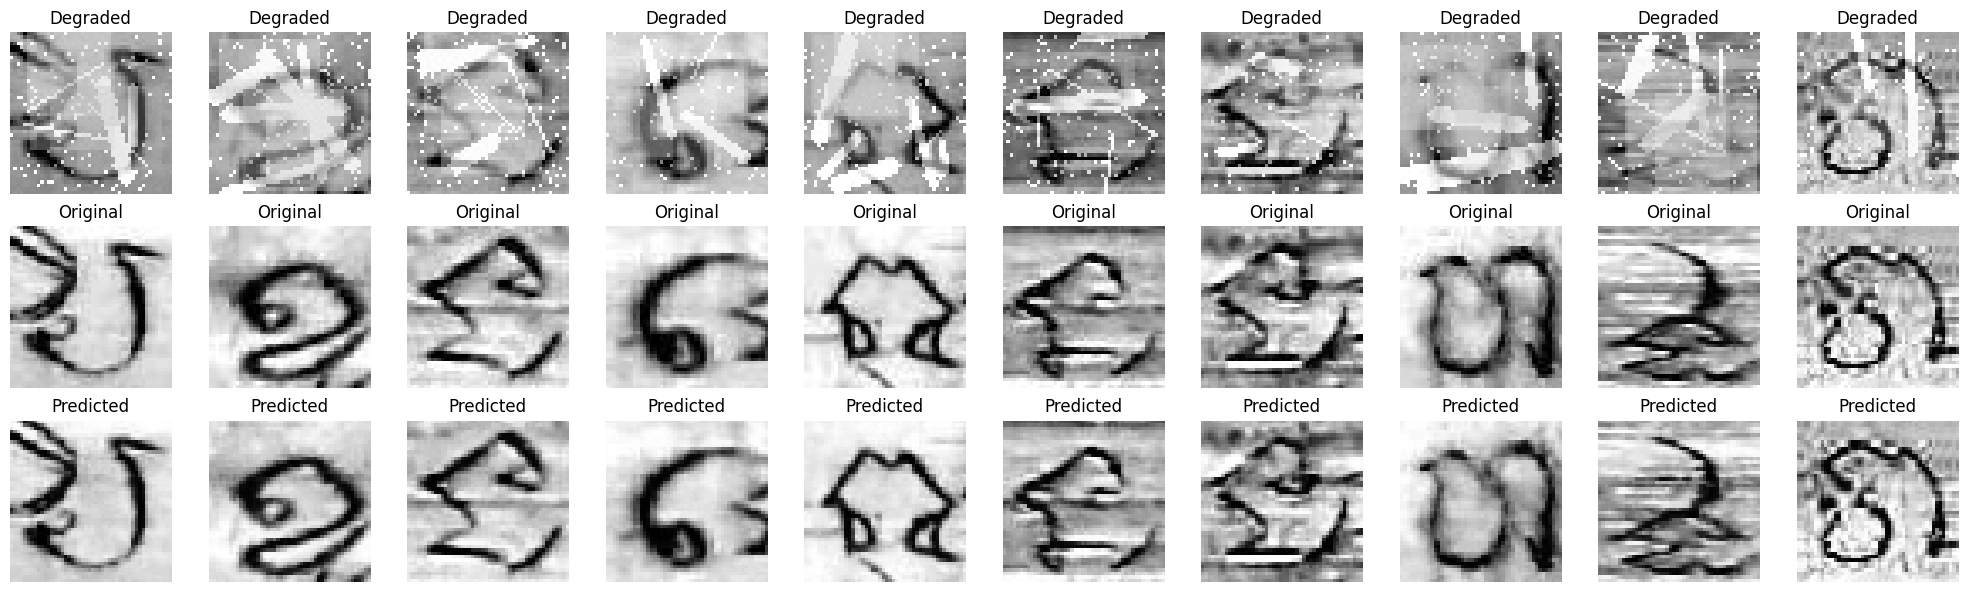

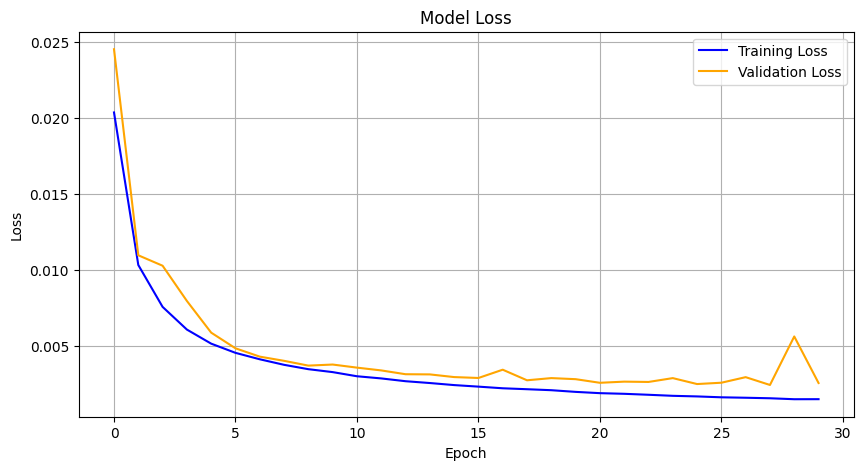

In [10]:
# Function to predict and display multiple outputs with random image selection
def predict_and_display_multiple(model, degraded_images, target_images, num_images=10):
    plt.figure(figsize=(20, 6))  # Increase figure width for better spacing

    # Randomly select indices for 10 images
    random_indices = np.random.choice(degraded_images.shape[0], num_images, replace=False)

    # Loop through the randomly selected images
    for i, idx in enumerate(random_indices):
        # Prepare the degraded image for prediction
        degraded_image_array = np.expand_dims(degraded_images[idx], axis=0)  # Add batch dimension

        # Make a prediction
        predicted = model.predict(degraded_image_array)

        # Squeeze the output to remove extra dimensions (1, 48, 48, 1) -> (48, 48)
        predicted = np.squeeze(predicted)

        # Display the original degraded, target, and predicted images
        plt.subplot(3, num_images, i + 1)
        original_img = np.squeeze(degraded_image_array)  # Remove extra dimensions for display
        plt.imshow(original_img, cmap='gray')
        plt.title(f"Degraded")
        plt.axis('off')

        plt.subplot(3, num_images, num_images + i + 1)
        target_img = np.squeeze(target_images[idx])  # Corresponding target image
        plt.imshow(target_img, cmap='gray')
        plt.title(f"Original")
        plt.axis('off')

        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(predicted, cmap='gray')
        plt.title(f"Predicted")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
# Predict and display the outputs for 10 randomly selected images from the validation set
predict_and_display_multiple(model, degrade_val, target_val, num_images=10)

# Function to plot training and validation loss
def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the loss graph (Make sure to replace `history` with your actual training history variable)
plot_loss(history)


In [11]:
# save model
model.save('/content/drive/MyDrive/complex_unet.h5')

938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 35ms/step
Complex Model - MSE: 0.0026, PSNR: 26.8130, SSIM: 0.9479


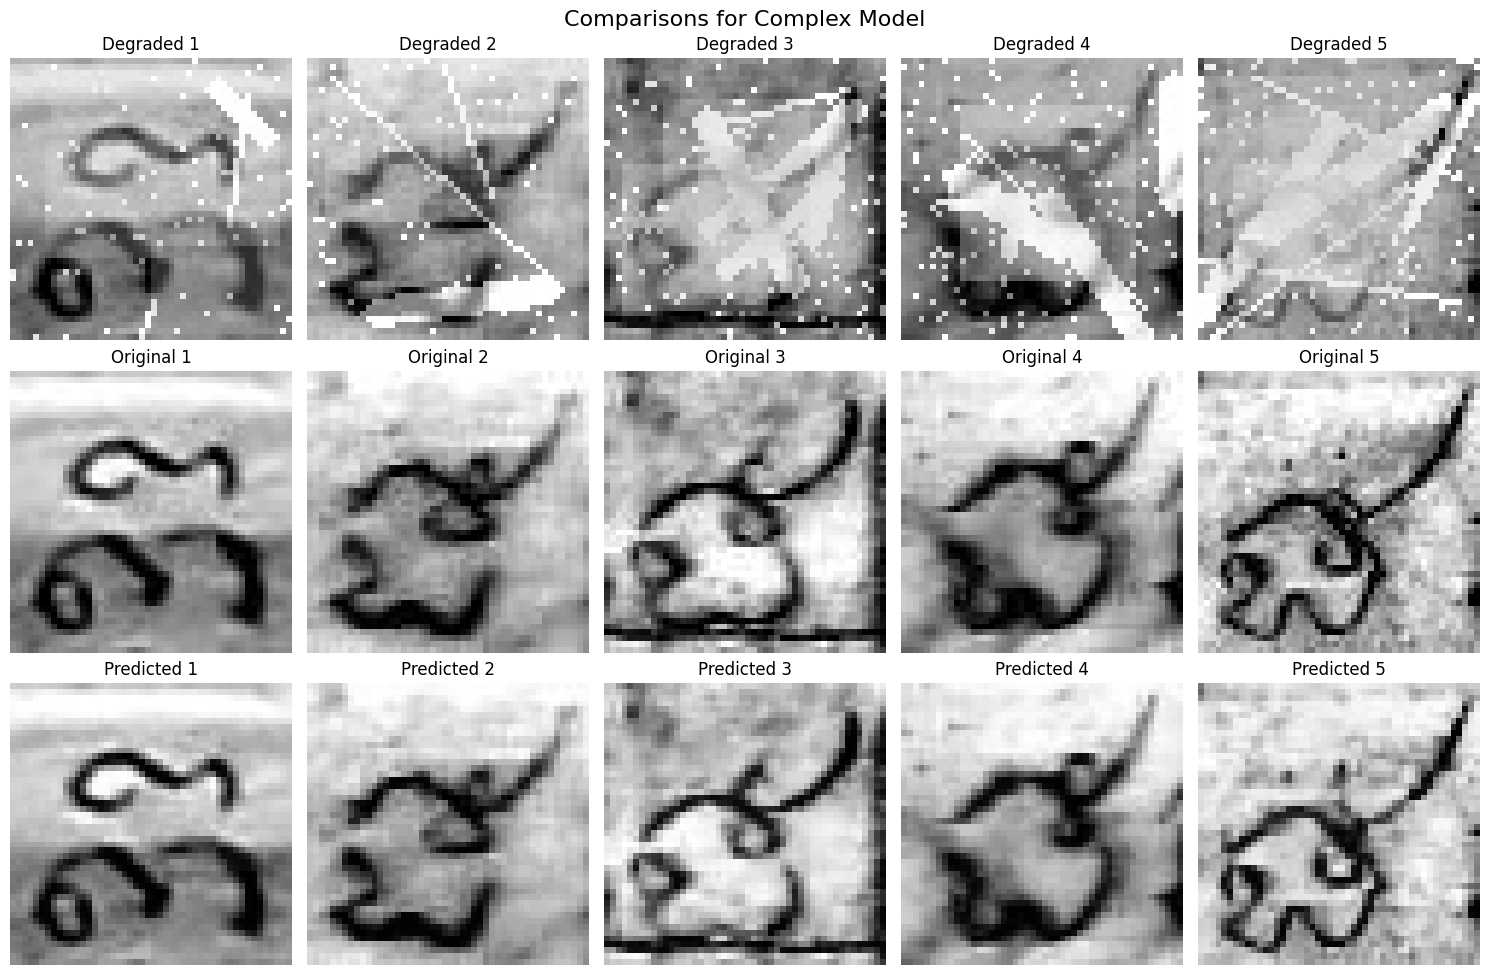

In [12]:
# Function to calculate PSNR
def psnr(target, predicted):
    mse = np.mean((target - predicted) ** 2)
    if mse == 0:  # To avoid division by zero
        return 100
    return 10 * np.log10(1 / mse)

# Function to evaluate a model and compute MSE, PSNR, and SSIM
def evaluate_model(model, test_images, ground_truth_images):
    predictions = model.predict(test_images)

    # Calculate MSE
    mse_value = mean_squared_error(ground_truth_images.reshape(num_test_images, -1),
                                   predictions.reshape(num_test_images, -1))

    # Calculate PSNR
    psnr_values = [psnr(ground_truth_images[i], predictions[i]) for i in range(num_test_images)]
    average_psnr = np.mean(psnr_values)

    # Calculate SSIM
    ssim_values = [ssim(ground_truth_images[i].squeeze(), predictions[i].squeeze(), data_range=1)
                   for i in range(num_test_images)]
    average_ssim = np.mean(ssim_values)

    return mse_value, average_psnr, average_ssim, predictions

# Function to plot original, degraded, and predicted images
def plot_comparisons(degraded_images, ground_truth_images, predictions, model_name, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        # Degraded Image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(degraded_images[i].squeeze(), cmap='gray')
        plt.title(f'Degraded {i+1}')
        plt.axis('off')

        # Original Image
        plt.subplot(3, num_images, num_images + i + 1)
        plt.imshow(ground_truth_images[i].squeeze(), cmap='gray')
        plt.title(f'Original {i+1}')
        plt.axis('off')

        # Predicted Image
        plt.subplot(3, num_images, 2 * num_images + i + 1)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title(f'Predicted {i+1}')
        plt.axis('off')

    plt.suptitle(f'Comparisons for {model_name}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Load test data from CSV files
test_df = pd.read_csv('/content/drive/MyDrive/testset_degraded.csv')  # Degraded images
test_images = test_df.values  # Convert to NumPy array

ground_truth_df = pd.read_csv('/content/drive/MyDrive//testset_original.csv')  # Ground truth images
ground_truth_images = ground_truth_df.values

# Reshape the data into image dimensions (48x48x1 in this case)
height, width, channels = 48, 48, 1
num_test_images = test_images.shape[0]

# Reshape and normalize the test images and ground truth
test_images_reshaped = test_images.reshape((num_test_images, height, width, channels))
ground_truth_images_reshaped = ground_truth_images.reshape((num_test_images, height, width, channels))

# Load the saved models
complex_model = load_model('/content/drive/MyDrive/complex_unet.h5')

# Evaluate the complex model
complex_mse, complex_psnr, complex_ssim, complex_predictions = evaluate_model(complex_model, test_images_reshaped, ground_truth_images_reshaped)
print(f'Complex Model - MSE: {complex_mse:.4f}, PSNR: {complex_psnr:.4f}, SSIM: {complex_ssim:.4f}')

# Plot comparisons for each model
plot_comparisons(test_images_reshaped, ground_truth_images_reshaped, complex_predictions, 'Complex Model')